In [16]:
import numpy as np
import scipy.stats as sps
import pandas as pd
from gaussian_mixture_anomaly_detection import GaussianMixtureInTimeAnomalyDetector
from gaussian_mixture_anomaly_detection import extract_anomaly_target
import matplotlib.pyplot as plt
%matplotlib inline

простой пример: 10 двумерных временных рядов по 10 элементов в каждом,лежащие на 3x=2y со случайным нормальным смещением, а также 4 аномальные точки

In [3]:
T = 10
F = 40
N = 2

data = np.zeros((F, T, N))

for i in range(F):
    for t in range(T):
        data[i][t] = np.array([2,3]) * t + sps.norm.rvs(size=2,scale=0.5)
        
anomalies = [(0,5,0), (1,3,1), (1,4,1), (2,8,1), (3,2,0)]
for a in anomalies:
    data[a[0]][a[1]][a[2]] += 5

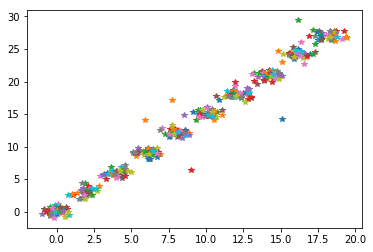

In [4]:
for i in range(F):
    plt.plot(data[i][:, 0], data[i][:, 1], '*')

In [5]:
detector = GaussianMixtureInTimeAnomalyDetector(n_components=10, random_state=1)

In [6]:
scores = detector.fit(data)  # scores  - лограифмическое правдоподобие нормальности для каждого сэмпла

Start probabilities memorization


выявление аномальных сэмплов:

In [7]:
detector.find_anomalies(scores, log_likelihood_threshold=0)

([(-10.62059670059655, (2, 8)),
  (-10.434144266789245, (1, 3)),
  (-5.2131952299718138, (1, 4)),
  (-3.9953222648668798, (0, 5)),
  (-1.9257217347682634, (25, 7)),
  (-1.3309074563629095, (6, 8)),
  (-0.98763094001917073, (6, 9)),
  (-0.96867671184160209, (19, 1)),
  (-0.95336024466996838, (31, 8)),
  (-0.9329747728855432, (14, 5)),
  (-0.90785422167005969, (23, 6)),
  (-0.75074499710418363, (27, 2)),
  (-0.60035827881138693, (32, 5)),
  (-0.56371270341470781, (4, 6)),
  (-0.53207856132538733, (34, 6)),
  (-0.36071655326223107, (6, 6)),
  (-0.22404500128215735, (21, 1)),
  (-0.18317763184908922, (13, 7)),
  (-0.14264951006876841, (39, 6)),
  (-0.088031631872965629, (2, 9)),
  (-0.070405431143623048, (36, 5)),
  (-0.053736762389048613, (24, 6))],
 0)

In [8]:
detector.find_anomalies(scores, anomaly_top=0.05)

([(-10.62059670059655, (2, 8)),
  (-10.434144266789245, (1, 3)),
  (-5.2131952299718138, (1, 4)),
  (-3.9953222648668798, (0, 5)),
  (-1.9257217347682634, (25, 7)),
  (-1.3309074563629095, (6, 8)),
  (-0.98763094001917073, (6, 9)),
  (-0.96867671184160209, (19, 1)),
  (-0.95336024466996838, (31, 8)),
  (-0.9329747728855432, (14, 5)),
  (-0.90785422167005969, (23, 6)),
  (-0.75074499710418363, (27, 2)),
  (-0.60035827881138693, (32, 5)),
  (-0.56371270341470781, (4, 6)),
  (-0.53207856132538733, (34, 6)),
  (-0.36071655326223107, (6, 6)),
  (-0.22404500128215735, (21, 1)),
  (-0.18317763184908922, (13, 7)),
  (-0.14264951006876841, (39, 6)),
  (-0.088031631872965629, (2, 9)),
  (-0.070405431143623048, (36, 5))],
 -0.070405431143623048)

как видно аномалии попали в топ 5%

In [9]:
detector.find_anomalies(scores, anomaly_top=0.1, strategy='series')

([(0.31147136026450228, 1),
  (4.1927254788374206, 2),
  (13.48323826619402, 6),
  (13.492912689670757, 27),
  (15.335017043795499, 25)],
 15.335017043795499)

2 ряда с добавленными аномалиями попали в топ по сумме логорифимических правдоподобий

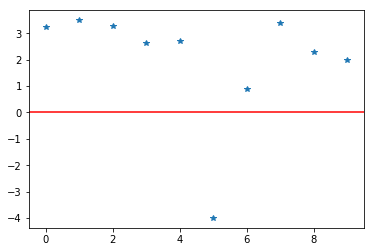

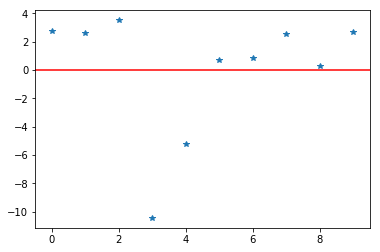

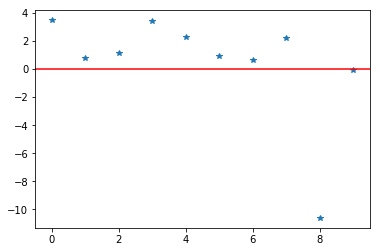

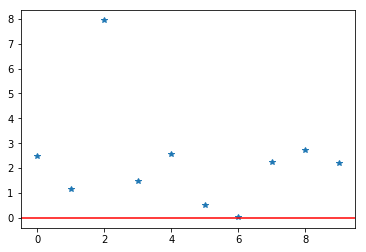

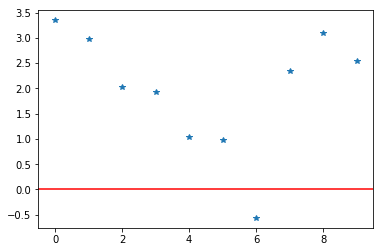

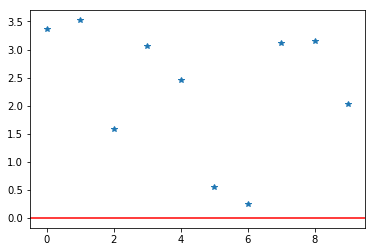

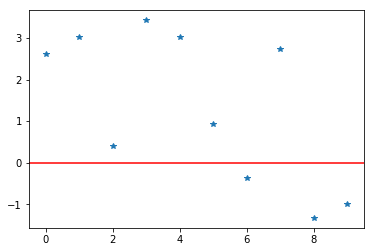

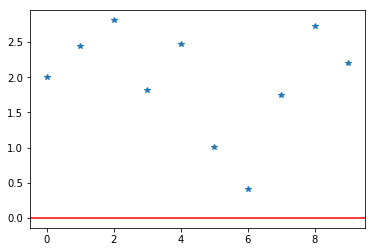

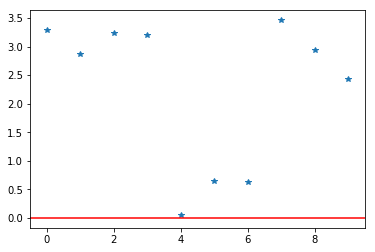

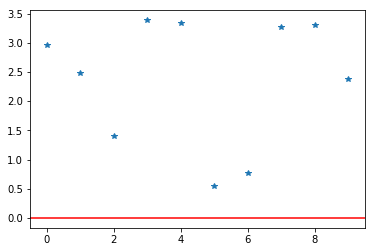

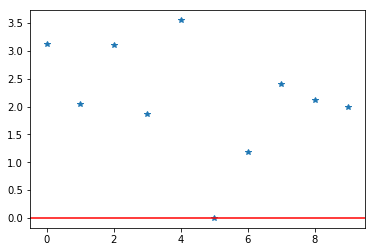

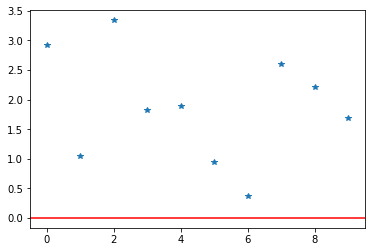

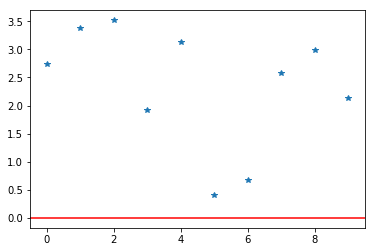

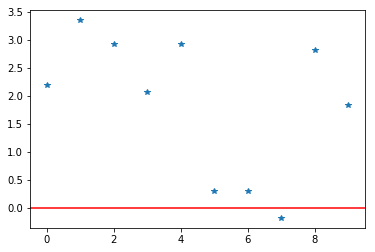

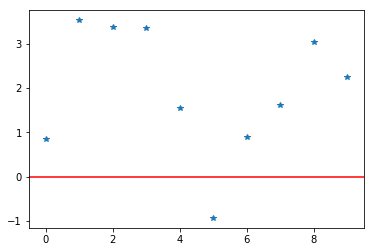

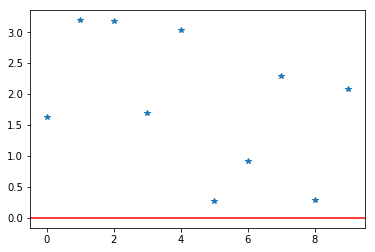

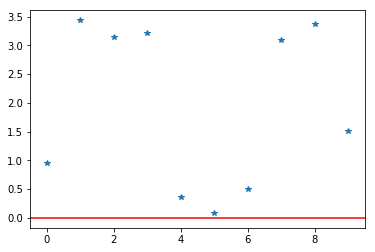

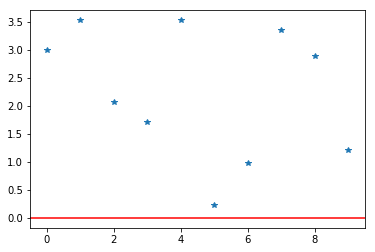

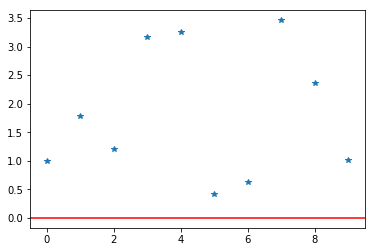

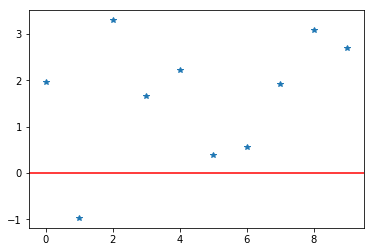

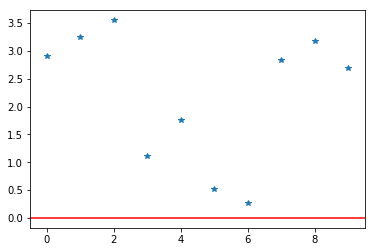

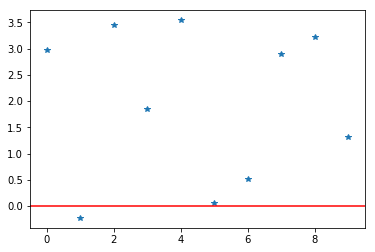

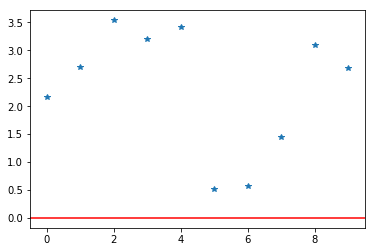

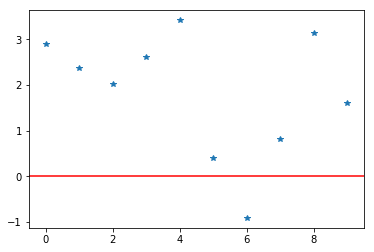

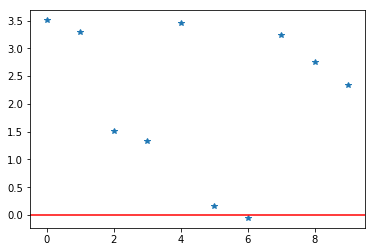

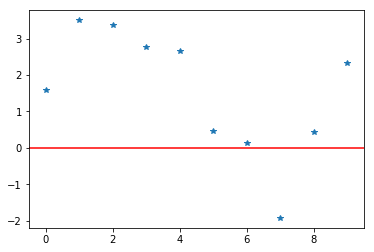

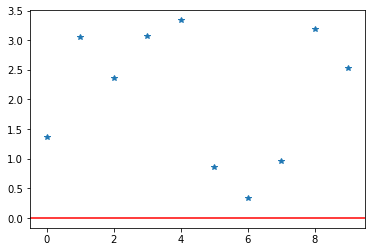

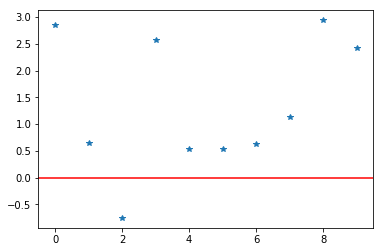

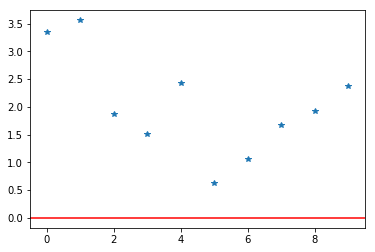

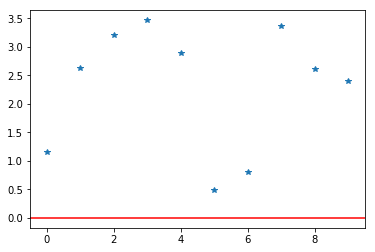

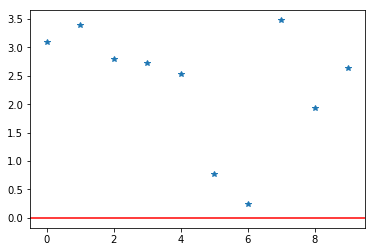

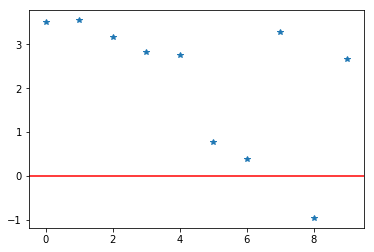

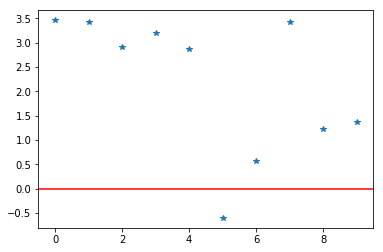

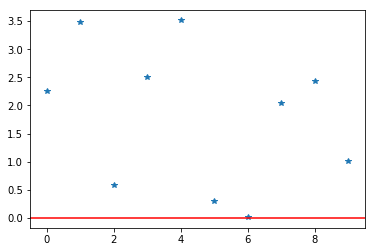

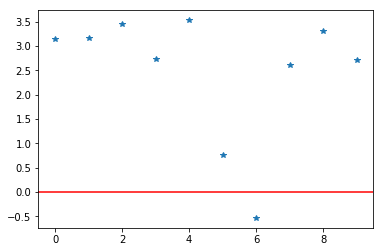

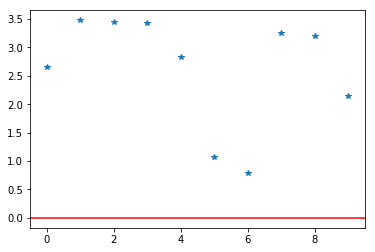

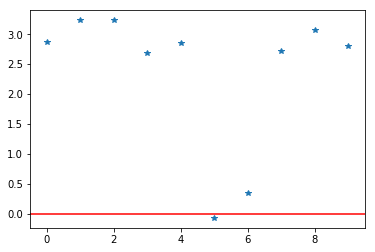

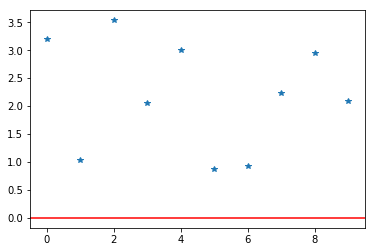

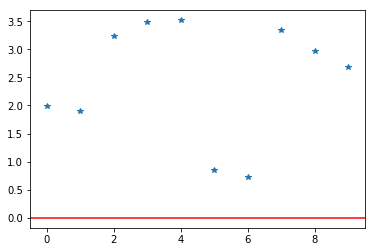

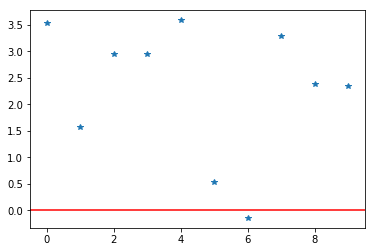

In [10]:
for f in range(F):
    plt.plot(range(T), scores[f],'*')
    plt.plot([-1, 10], [0,0],'r')
    plt.xlim([-0.5, 9.5])
    plt.show()

In [10]:
smoothed_scores = detector.smoothed_sample_anomalies(scores, halflife=2)

/Users/sergmiller/Documents/code/python/FlightAnomaliesDetection/gaussian_mixture_anomaly_detection.py:171: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()
  return np.array([np.array(pd.ewma(series, halflife)).reshape(-1) for series in frames])


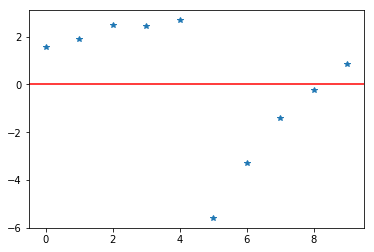

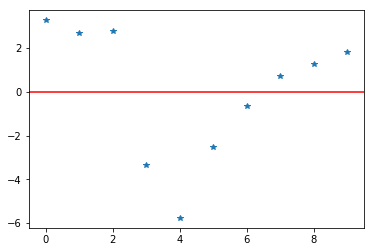

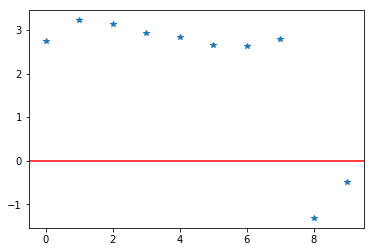

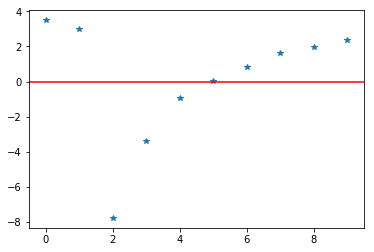

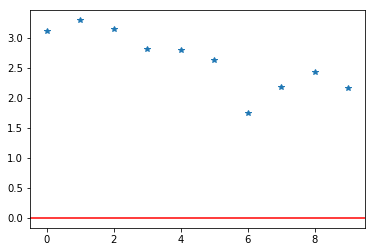

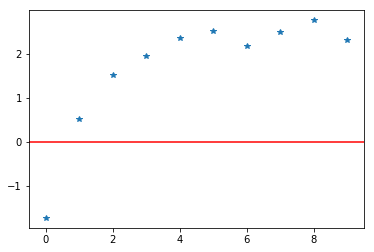

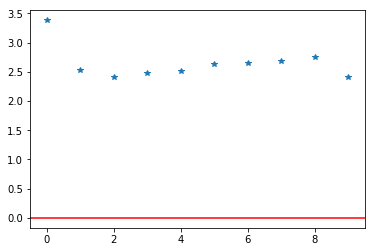

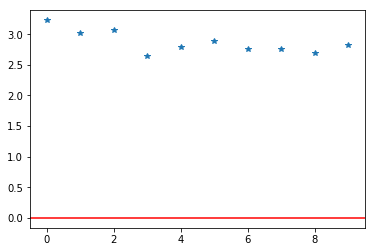

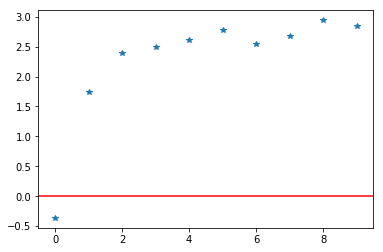

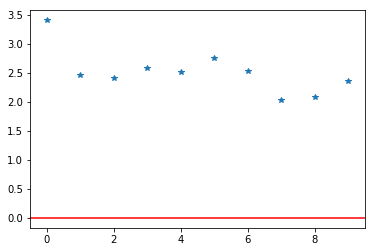

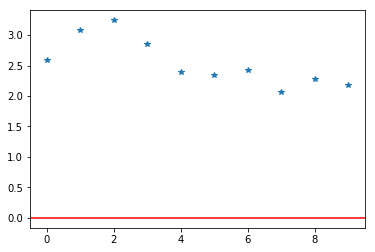

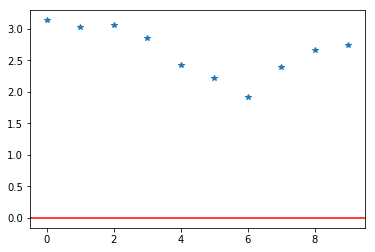

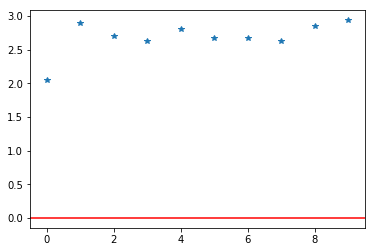

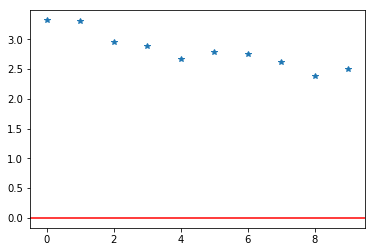

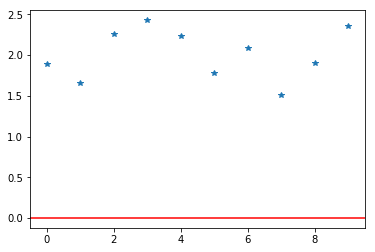

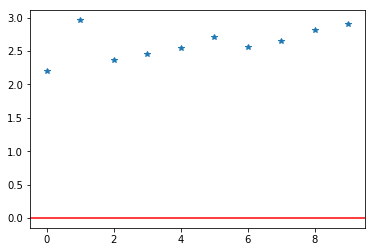

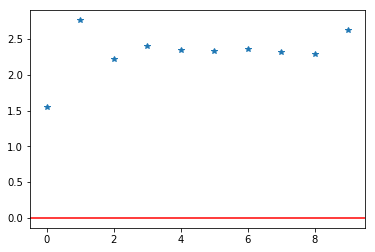

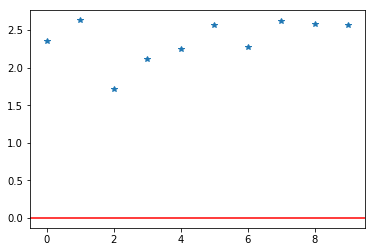

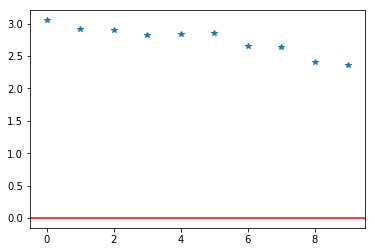

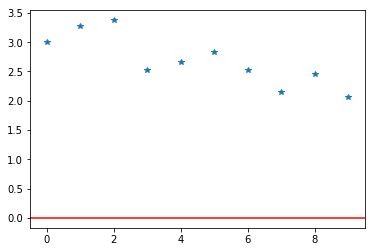

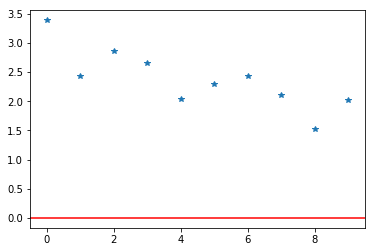

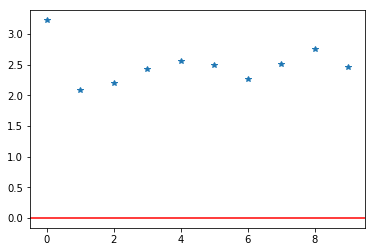

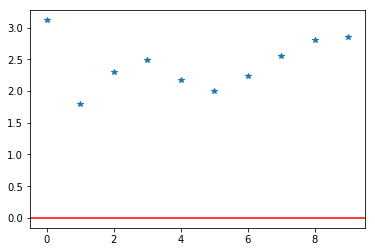

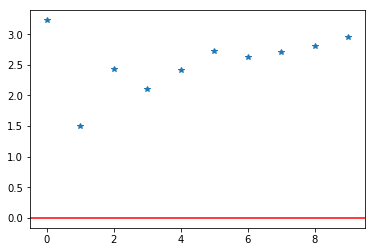

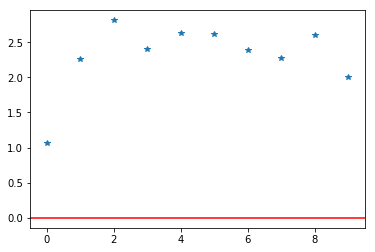

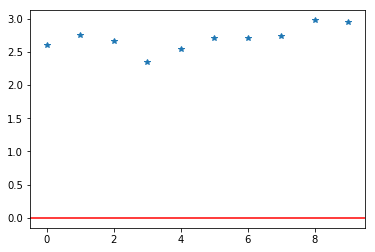

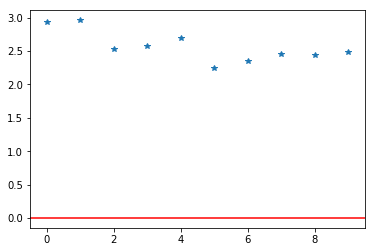

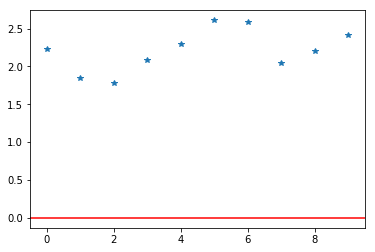

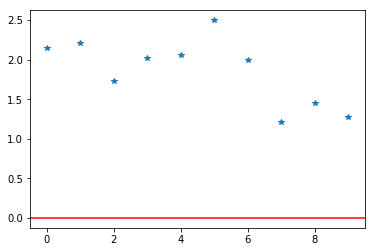

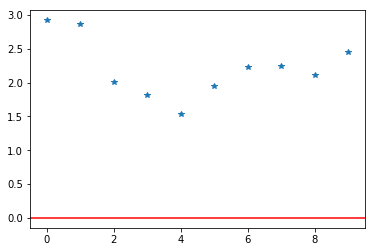

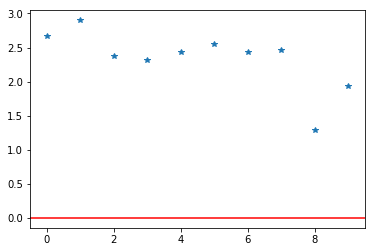

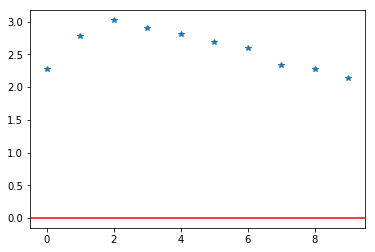

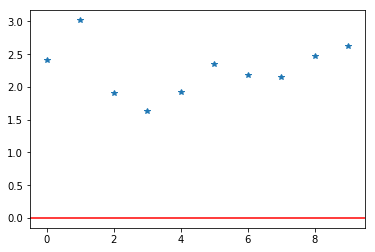

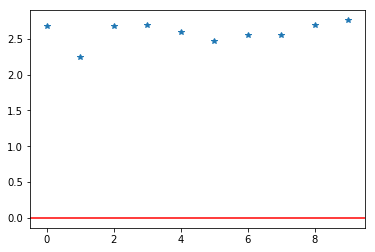

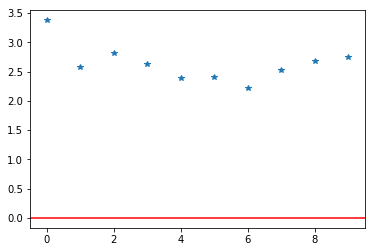

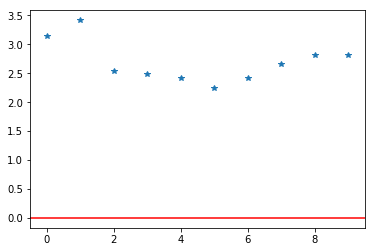

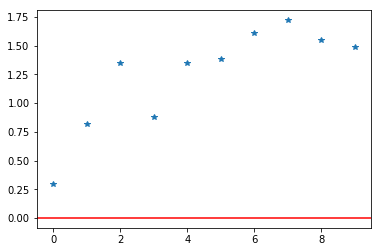

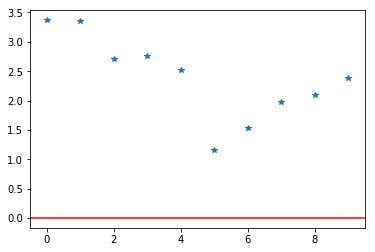

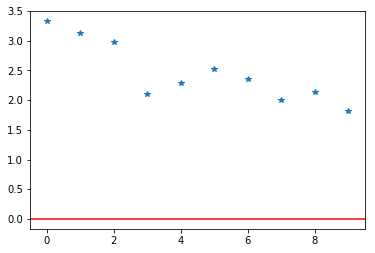

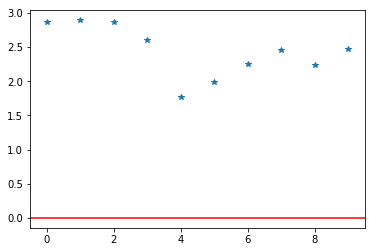

In [11]:
for f in range(F):
    plt.plot(range(T), smoothed_scores[f],'*')
    plt.plot([-1, 10], [0,0],'r')
    plt.xlim([-0.5, 9.5])
    plt.show()

In [17]:
targets =  extract_anomaly_target(pd.DataFrame(data.reshape(40 * 10, 2)), 40, 1, 2, 10, 0.01)

Start probabilities memorization


/Users/sergmiller/Documents/code/python/FlightAnomaliesDetection/gaussian_mixture_anomaly_detection.py:170: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=1,min_periods=0,adjust=True,ignore_na=False).mean()
  return np.array([np.array(pd.ewma(series, halflife)).reshape(-1) for series in frames])


In [18]:
targets2d = targets.reshape((40,10))
for f in range(F):
    plt.plot(range(T), smoothed_scores[f],'*')
    plt.plot([-1, 10], [0,0],'r')
    plt.xlim([-0.5, 9.5])
    plt.show()
    print(targets2d[f])

NameError: name 'smoothed_scores' is not defined